In [135]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [136]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
#sys.path.append('../')

from importlib import reload
import Utils.utils as util
reload(util)


from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize

np.set_printoptions(threshold=np.inf) #print full arrays
from sklearn import linear_model


In [137]:
def split_patch(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    pixel_central = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    patch_sans_central = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((patch_sans_central, pixel_central))
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    #patch = patch.flatten()
    h = patch.shape[0]
    patch = np.reshape(patch, h*h*3)
    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def find_index_noisy_lines(label):
    """
    indexes = []
    for index, value in enumerate(label):
        if(value == -1):
            indexes.append(index)
    """
    label = np.array(label)
    indexes = np.where(label < 0)
    return indexes

def delete_all_indexes_from(dictionary, label):
    indexes = find_index_noisy_lines(label)
    dictionary = np.delete(dictionary, indexes , 0)
    label = np.delete(label, indexes , 0)
    
    return (dictionary, label)    

#test the alpha on a lot of cleared patches and returns an average value
def estimate_alpha(noisy_image, dictionary_full, h):
    lassocv = linear_model.LassoCV()
    listalpha = []
    width = noisy_image.shape[1]
    height = noisy_image.shape[0]
    #params
    pas = h+10
    start = h//2
    endx = height-h//2
    endy = width-h//2
    #end params
    i=0
    total = int( (endx-pas)/pas * (endy-pas)/pas )
    for x in range(start,endx,pas):
        for y in range(start,endy,pas):
            label = util.get_patch(x, y, h, noisy_image)
            label = list(convert_patch_into_vector(label))
            dictionary, label = delete_all_indexes_from(dictionary_full,label)
            lassocv.fit(dictionary_full, label)
            alpha_ = lassocv.alpha_
            listalpha.append(alpha_)
            i+=1
            if(i%10==0): print(i, "/", total)
    return np.mean(np.array(listalpha))
    
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        #raise ValueError('array not found in list.') #todo, why am I getting this one in optimized mode
        print('ERROR:  removearray(L,arr): array not found in list.')

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h, clear_image):
    noisy_image_orig = np.array(noisy_image)
    dictionary_full = np.array(dictionary)
    
    #todo question: vérifier qu'il faut bien faire le lassocv pour trouver le alpha sur le clear?
    lassocv = linear_model.LassoCV(max_iter=1000)  #1000 by default, 100 works OK
    """
    y, x = coord_noisy_pix[0]
    label = util.get_patch(x, y, h, noisy_image)
    #label = util.get_patch(x, y, h, clear_image)
    label = list(convert_patch_into_vector(label))
    lassocv.fit(dictionary_full, label)
    alpha_ = lassocv.alpha_
    """
    #alpha_ = estimate_alpha(noisy_image, dictionary_full, h)
    #autre idée: en prendre 10 aléatoirement
    alpha_ = 92 #calculé pour 12.jpg
    
    #alpha_ = 0.01
    
    print("alpha = ", alpha_)
       
    i = 0
    nbiter  = int(len(coord_noisy_pix))
    while i < nbiter: # DONT USE FOR FOR THIS BECAUSE WE WILL MODIFY THE LIST
        y, x  = coord_noisy_pix[i] 
        
        if(i%10==0): print( i, " / ",  nbiter)
        
        #print("Correction de : (", x, ", ", y,")")
        patch = util.get_patch(x, y, h, noisy_image)
        labelfull = list(convert_patch_into_vector(patch))
        
        #print("labelfull : ", labelfull)
        
        dictionary = np.array(dictionary_full)
        dictionary, label = delete_all_indexes_from(dictionary,labelfull)

        #print("--- lasso regression ---")
        
        #recalcule du alpha à chaque patch
        if(i%1==0) :
            lassocv.fit(dictionary, label)
            alpha_ = lassocv.alpha_
            print("alpha = ", alpha_)
    
        #fin recalcule du alpha
        
        model = Lasso(fit_intercept=True,alpha=alpha_,positive=True)
        
        model.fit(dictionary, label)
        
        #################################################
        #version somme cumulée
        res = model.predict(dictionary_full)
        
        #version argmax
        #print("argmax = ",np.argmax(model.coef_)," / ", model.coef_.shape)
        #res = dictionary_full.T[np.argmax(model.coef_)]
        #################################################
        
        #################################################
        #coef = model.coef_.reshape((1,-1)) #poids
        #print("nb patch not at zero: ", np.count_nonzero(model.sparse_coef_.toarray()), " / ", coef.shape[1])
       
        # corrige juste le pixel central
        #"""
        # and use x, y  = coord_noisy_pix[i]  at the beginning of the while
        newPixel = util.get_centered_pixel(res, h)
        print("new pixel (lasso): ", newPixel)
        noisy_image[x][y] = newPixel
        i=i+1
        #"""
        
        """
        # corrige tous les pixels noirs dans le patch
        # and use x, y  = coord_noisy_pix[0] at the beginning of the while
        
        labelfull = np.array(labelfull)
        list_indexes_noise = np.where(labelfull < 0)[0]     
        #print(list_indexes_noise)   
        indexeach3 = list(range(0,len(list_indexes_noise),3))
        listindexes2 = list_indexes_noise[indexeach3] #on prend que 1 sur 3 car 3 valeurs par pixel
        xpatch = x-h//2
        ypatch = y-h//2
        for val in listindexes2:
            val = (val/3)
            xlocal = int((val)//h)
            ylocal = int(val-(xlocal)*h)
            #print("xlocal = ",xlocal," ylocal=",ylocal)
            xglobal = xpatch + xlocal
            yglobal = ypatch + ylocal
            #print("xglobal=",xglobal," yglobal=",yglobal)
            patch = res.reshape(h,h,3)
            newpixel = patch[xlocal, ylocal]
            noisy_image[xglobal][yglobal] = newpixel
            #supprimer de la liste pour pas le refaire
            coord_noisy_pix = list( coord_noisy_pix)
            currentpixel = [xglobal, yglobal] #ok vérifié
            #print("remove : ", currentpixel)
            
            removearray(coord_noisy_pix, np.array(currentpixel))
            coord_noisy_pix = list( coord_noisy_pix)
            #print("left to correct : ",len(coord_noisy_pix))
            i = i + 1
            if(i%10==0): print( i, " / ",  nbiter)
            
        util.display_im(noisy_image)
       #"""    
        #################################################
        
        #Test  -> reconstruire de nouveaux patch à partir des pixels corrigés ?
        #_,clear_patches = util.get_patches(noisy_image, h, width, height)
        #dictionary_full = convert_patches_into_training_set(clear_patches)
        #print("shape : ", dictionary_full.shape)

    util.display_im(noisy_image_orig)
    util.display_im(noisy_image)

taille de l'image :  (100, 100, 3)
nb pixels à corriger:  (76, 2)
100  ,  100
nbclear: 395


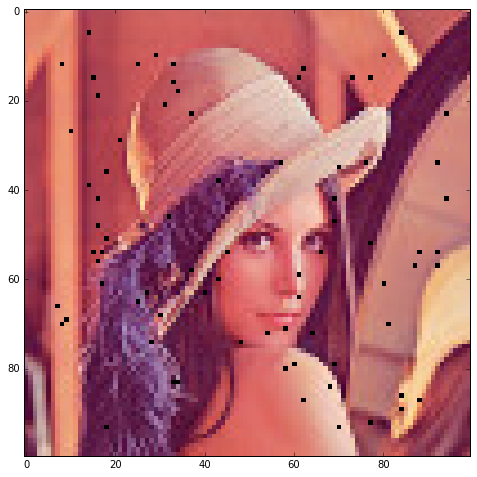

In [138]:
%matplotlib inline
img_matrice = util.read_im("Data/imgdataset/lennasmall.jpg")

print("taille de l'image : ", img_matrice.shape)

#util.display_im(img_matrice)

#Taille des patchs
h=5 #nombre impair !!

width = img_matrice.shape[1]
height = img_matrice.shape[0]
noisy_image, deletepixels = util.noise(img_matrice, 0.01, width, height, h);

#noisy_image, deletepixels = util.delete_rect(img_matrice, 10, 10, 10, 10) #66, 55, 75, 15

#10small 65, 50, 80, 15
#12.jpg 85, 75, 30, 6

print("nb pixels à corriger: ", np.array(deletepixels).shape)

width = img_matrice.shape[1]
height = img_matrice.shape[0]

print(width," , ", height)

util.display_im(noisy_image)

_,clear_patches = util.get_patches(noisy_image, h, width, height)

nbclear = np.shape(clear_patches)[0]
print("nbclear:", nbclear)

In [139]:
training = convert_patches_into_training_set(clear_patches)
print(training.shape)

(75, 395)


In [140]:
a = np.array([[1, 'a'], [2, 'a'], [3, 'a'], [4, 'a'], [5, 'a'], [6, 'a'], [7, 'a'], [8, 'a'], [9, 'a']])
print(a.shape)    
a = a.reshape(3,3,2)
print(a.shape)
print("center=",util.get_centered_pixel(a, 3))

#coefsize = (1, 2510)   dicofullsize = (27, 2510)  ressize= (27, 2510)
coef = np.array([0,1,2])
coef = coef.reshape(-1,1)
print(coef.shape)
dico = [1,2,3]
coef.T*dico



spyral_transformation(a)

(9, 2)
(3, 3, 2)
center= ['5' 'a']
(3, 1)


array([['1', 'a'],
       ['2', 'a'],
       ['3', 'a'],
       ['6', 'a'],
       ['9', 'a'],
       ['8', 'a'],
       ['7', 'a'],
       ['4', 'a'],
       ['5', 'a']],
      dtype='<U21')

1  2  3  4
5  6  7  8
9 10 11 12

alpha =  92
0  /  76


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1.19897125772
new pixel (lasso):  [ 96.33340658  34.33363195  77.3924893 ]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  79.9922796019
new pixel (lasso):  [ 90.79055798  30.86280874  73.38522363]
alpha =  157.367582695
new pixel (lasso):  [ 189.53676434   95.52096232   91.57744129]
alpha =  131.328660893
new pixel (lasso):  [ 220.09597167  119.59800507  107.0397536 ]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  5.35491448214
new pixel (lasso):  [ 175.35555617   66.89510336   78.57937182]
alpha =  63.2490412938
new pixel (lasso):  [ 94.99743455  37.825233    76.54911151]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  132.960106481
new pixel (lasso):  [ 219.63983243  187.01022771  177.89351225]
alpha =  23.3083059254
new pixel (lasso):  [ 121.64524738   28.16647711   76.53648547]
alpha =  355.003240741
new pixel (lasso):  [ 171.23109677   70.40144844   83.86693279]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  9.38121616359
new pixel (lasso):  [ 261.96190987  208.97729517  164.99365083]
10  /  76


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  28.2462275991
new pixel (lasso):  [ 217.63284581  107.48974376  107.10832965]
alpha =  216.231384251
new pixel (lasso):  [ 224.60842139  147.86399598  147.75116725]
alpha =  27.7155166175
new pixel (lasso):  [ 108.89953927   29.54493126   61.94443958]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  8.63659820273
new pixel (lasso):  [ 172.56795222   63.93213603   78.56765029]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  4.43354507929
new pixel (lasso):  [ 208.82740625  143.34152983  128.15023465]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  4.96695010853
new pixel (lasso):  [ 179.28659359   69.43882759   81.59551475]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  45.2367528364
new pixel (lasso):  [ 229.95318668  125.60831249  119.7189371 ]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  12.605379443
new pixel (lasso):  [ 199.51540985  122.27841235  152.31425864]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  16.9564580323
new pixel (lasso):  [ 223.08505127  183.32638342  168.62565898]
alpha =  18.00192
new pixel (lasso):  [ 235.8142248   183.25249869  159.8182914 ]
20  /  76
alpha =  20.6251110762
new pixel (lasso):  [ 186.88192096   84.53384704  110.55614403]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.21247530864
new pixel (lasso):  [ 175.73519553   88.89532343  119.57602569]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.90583551867
new pixel (lasso):  [ 179.52519989   67.78414918   83.3203101 ]
alpha =  321.168
new pixel (lasso):  [ 199.62755893  115.11177674  127.87893468]
alpha =  8.69103500368
new pixel (lasso):  [ 173.54706156   66.75701144   83.28594357]
alpha =  25.9877889543
new pixel (lasso):  [ 221.23092345  176.13008908  168.47623013]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  49.3723513155
new pixel (lasso):  [ 98.46802885  15.46169828  54.10145072]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  357.606185831
new pixel (lasso):  [ 220.4121876   117.84881557  119.36730673]
alpha =  158.250807353
new pixel (lasso):  [ 217.40163986  110.89023654  112.50974812]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  33.6742423142
new pixel (lasso):  [ 223.51505028  126.70037994  110.1191461 ]
30  /  76


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.04209333333
new pixel (lasso):  [ 210.82774378   96.68559478  105.35771948]
alpha =  44.4179889593
new pixel (lasso):  [ 191.06456787   90.14478759  113.81660591]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.68195150707
new pixel (lasso):  [ 154.42868446   65.19358608   85.66590849]
alpha =  378.681511189
new pixel (lasso):  [ 184.18778288   93.15027108   97.17241973]
alpha =  52.2619788837
new pixel (lasso):  [ 227.72765523  159.5191991   136.3156689 ]
alpha =  73.2007420505
new pixel (lasso):  [ 211.45200505  111.95720955  121.54992326]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.17377141204
new pixel (lasso):  [ 214.19057597  138.97251298  128.38573595]
alpha =  510.641216511
new pixel (lasso):  [ 156.80953861   64.87644628   94.40368222]
alpha =  45.6955093194
new pixel (lasso):  [ 198.18724444  116.45015892  118.30379454]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  13.3698722961
new pixel (lasso):  [ 120.85869999   37.6738681    81.58384214]
40  /  76
alpha =  2.58577493333
new pixel (lasso):  [ 214.95315525  121.06897199  113.08409828]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  34.4277137163
new pixel (lasso):  [ 247.59973724  195.23587476  182.71623919]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.95689706667
new pixel (lasso):  [ 222.25422774  121.45632832  112.84978712]
alpha =  110.933020321
new pixel (lasso):  [ 184.19474215   77.71390742   81.68625614]
alpha =  73.7904293277
new pixel (lasso):  [ 231.32691666  148.59512451  124.35719385]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  14.0114254018
new pixel (lasso):  [ 204.68705042  133.12371369  119.55439821]
alpha =  79.9660888226
new pixel (lasso):  [ 225.37451788  185.83120205  177.63708946]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  197.288187416
new pixel (lasso):  [ 111.52328726   61.26216167  101.49028717]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.79524003995
new pixel (lasso):  [ 103.47256785   22.90789424   65.5873069 ]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  9.04372191149
new pixel (lasso):  [ 89.3988174   17.60504685  61.16985736]
50  /  76


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  47.7791835725
new pixel (lasso):  [ 215.56495244  114.3013348   108.0473908 ]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  11.8718791966
new pixel (lasso):  [ 233.21648265  126.54585181  103.48791364]
alpha =  19.1797740304
new pixel (lasso):  [ 137.75759423   53.28312782   97.6221286 ]
alpha =  45.5975475527
new pixel (lasso):  [ 148.43155667   60.10875574  106.14423519]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  16.2176843831
new pixel (lasso):  [ 227.24184571  121.38071975  111.24550571]
alpha =  5.41154549139
new pixel (lasso):  [ 97.5667456   34.23217718  76.93377054]
alpha =  9.93285580204
new pixel (lasso):  [ 116.63919982   49.22247861   95.7812856 ]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  11.5009681355
new pixel (lasso):  [ 115.87811111   22.89124469   78.23370153]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  17.696982443
new pixel (lasso):  [ 230.44653367  197.34325097  190.4282826 ]
alpha =  10.6933655983
new pixel (lasso):  [ 93.44780519  24.00226042  66.14940081]
60  /  76
alpha =  34.7181341294
new pixel (lasso):  [ 96.51669604  29.70700759  65.60591503]
alpha =  516.557140445
new pixel (lasso):  [ 96.0550613   36.38569667  72.84967313]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  746.329768453
new pixel (lasso):  [ 167.20470483  114.74200202  112.52339702]
alpha =  8.12206313782
new pixel (lasso):  [ 94.39852829  23.43028943  60.70070585]
alpha =  60.9509028999
new pixel (lasso):  [ 202.01456328   91.04568289   89.29422386]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  451.561298851
new pixel (lasso):  [ 206.05430025  145.45631493  139.37453026]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.1487046885
new pixel (lasso):  [ 243.02645482  182.91483343  168.68626699]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  43.4947731413
new pixel (lasso):  [ 197.43856316  127.93445002  122.30912554]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  158.122513018
new pixel (lasso):  [ 208.0757702   123.92176111  118.9407858 ]
alpha =  70.9119466186
new pixel (lasso):  [ 174.71446457   78.64540617   92.68564383]
70  /  76
alpha =  94.00764933
new pixel (lasso):  [ 207.6301806   118.5974628   123.19641973]
alpha =  58.7529642114
new pixel (lasso):  [ 239.20564696  199.07617852  184.57217605]
alpha =  117.014820996
new pixel (lasso):  [ 204.25548985  105.70185776  107.42617896]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  11.6669857438
new pixel (lasso):  [ 227.93815568  184.96650854  169.95335944]


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  5.75451084961
new pixel (lasso):  [ 228.14147127  157.15296117  136.17410492]
alpha =  75.236629828
new pixel (lasso):  [ 96.41572459  22.66584609  67.95929802]


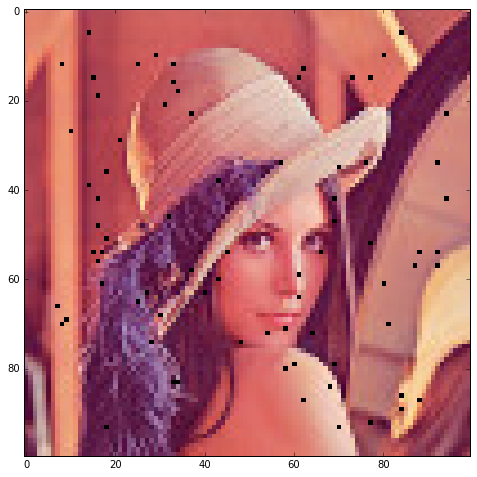

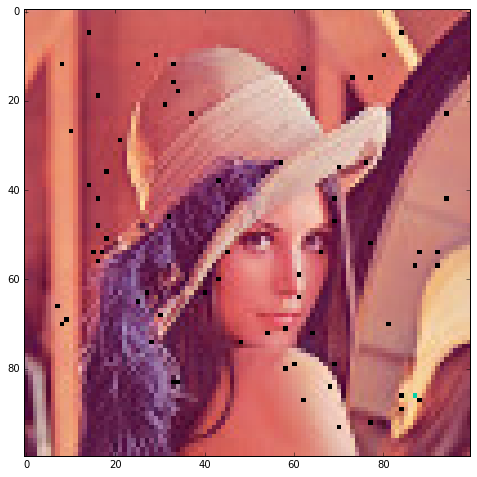

In [141]:
deletepixels_transformed = util.spyral_transformation(np.array(deletepixels))

inpaint_image(noisy_image, training, deletepixels_transformed, h, img_matrice)